## Problem Understanding

COVID-19 pandemic made a lot of tour and travel companies unable to operate their business as usual, due to the lockdown and travel restrictions. In early 2022, the infection rate of COVID-19 decreases, so the travel restrictions are slowly lifted and people begin to travel again. But, the COVID-19 still presents in our daily lives, there is still a risk to be infected while on traveling. To travel safely, people need travel insurance to minimize the cost of healthcare if they ever get a severe illness while traveling. Tour and travel companies need to learn the pattern of customers who are likely to claim the insurance based on various information from previous customers. Being able to predict the likelihood of a customer claiming the travel insurance package, help the company to better allocate their resource to the potential customer faster.

## Data Source and Description

Data source are from dphi data challenges. It can be downloaded from this [link](https://dphi.tech/challenges/travel-insurance-claim-prediction/49/overview/about). The following below are descriptions for each variables in this dataset.

* Duration: Travel duration

* Destination: Travel destination

* Agency: Agency Name

* Commission: Commission on the insurance

* Age: Age of the insurance buyer

* Gender: Gender of the insurance buyer

* Agency Type: What is the agency type?

* Distribution Channel: offline/online

* Product Name: Name of the insurance plan

* Net Sales: Net sales

* Claim: If the insurance is claimed or not (the target variable), 0 = not claimed, 1 = claimed

## Dependecies

In [1]:
import dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection

## Load Dataset

In [2]:
df = dataset.load_dataset("../dataset/Training_set_label.csv")
display(df.shape, df.head())

(48260, 11)

,agency,agency_type,distribution_channel,product_name,duration,destination,net_sales,commision_(in_value),gender,age,claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


There are 48260 observations and 11 variables. We noticed missing values are present in this dataset

## Exploratory Data Analysis

### Check duplicated data

In [3]:
df.duplicated().any()

True

In [4]:
df[df.duplicated()].shape

(5893, 11)

Around 12% observations are duplicated. We need to remove this duplicated data.

In [5]:
print(f"before drop duplicates: {df.shape}")

df = df.drop_duplicates()
print(f"after drop duplicates: {df.shape}")

before drop duplicates: (48260, 11)
after drop duplicates: (42367, 11)


The following command are used to split the dataset into 90% train set and 10% test set with stratified sampling to keep the target class ratio same for both train and test set. We use train set for exploratory data analysis and modelling, while test set are treated as unseen data to test the model performance more objective.

In [6]:
full_train, test = dataset.split_dataset(df, target='claim', test_size=0.1, seed=42)

print(f"full train shape: {full_train.shape}")
print(f"test shape: {test.shape}")

full train shape: (38130, 11)
test shape: (4237, 11)


For the rest of exploratory, we will use full_train insted a whole dataset.

### Missing value and data type

In [12]:
dataset.missing_values(full_train)

,variable,no_unique,pandas_dtype,missing_value,%_missing_values,unique_value
0,agency,16,object,0,0.000000,"[JZI, EPX, C2B, ART, SSI, CWT, CSR, RAB, TST, ..."
1,agency_type,2,object,0,0.000000,"[Airlines, Travel Agency]"
2,distribution_channel,2,object,0,0.000000,"[Online, Offline]"
3,product_name,26,object,0,0.000000,"[Basic Plan, Cancellation Plan, 1 way Comprehe..."
4,duration,438,int64,0,0.000000,"[19, 7, 13, 11, 14, 9, 44, 15, 37, 10, 90, 36,..."
5,destination,139,object,0,0.000000,"[VIET NAM, THAILAND, SINGAPORE, PHILIPPINES, M..."
6,net_sales,974,float64,0,0.000000,"[18.0, 23.0, 61.0, 31.8, 111.21, 0.0, 2.64, 22..."
7,commision_(in_value),901,float64,0,0.000000,"[6.3, 0.0, 7.95, 38.92, 0.74, 7.7, 11.75, 23.7..."
8,gender,2,object,26520,69.551534,"[M, nan, F]"
9,age,88,int64,0,0.000000,"[38, 30, 36, 45, 48, 49, 34, 54, 26, 31, 61, 6..."


This dataset contains 6 categorical variables denoted by object type, 4 numerical variables (float or int type), and 1 target variable (int type). The only variable with missing values is gender that accounted for 69.5% observations. In order to avoid bias toward either gender when filling the missing values with its mode, we must not use this for exploring dataset and bulding a model. The following are the list of categorical and numerical features.

In [8]:
numerical = df.select_dtypes(np.number).columns.tolist()
categorical = df.select_dtypes('O').columns.tolist()

print(f"numerical: {numerical}")
print(f"categorical: {categorical}")

numerical: ['duration', 'net_sales', 'commision_(in_value)', 'age', 'claim']
categorical: ['agency', 'agency_type', 'distribution_channel', 'product_name', 'destination', 'gender']


### Target variable: Distribution

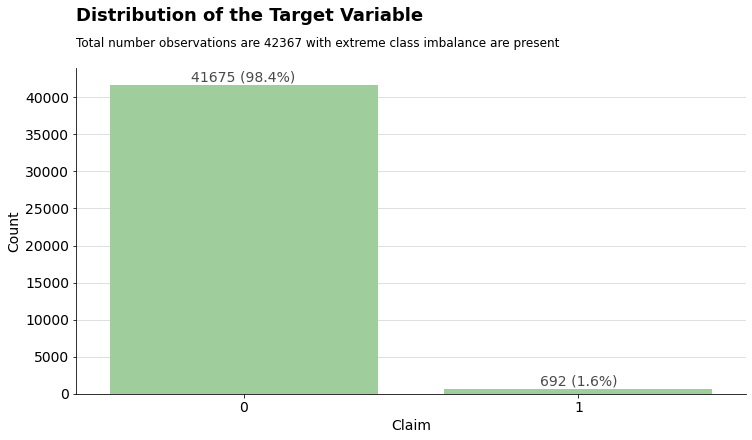

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = ['#99d594', '#D53E4F', '#FC8D59']
var = 'claim'

sns.countplot(data=df, x=var, ax=ax, color=colors[0])
feat_counts = df[var].value_counts().sort_index().values

for n, count in enumerate(feat_counts):
    ax.annotate(
        f"{count} ({(100* count/np.sum(feat_counts)):.1f}%)",
        xy=(n, count + 1000),
        color='#4a4a4a', fontsize=14, alpha=1,
        va = 'center', ha='center',
    )
for location in ['top', 'right']:
    ax.spines[location].set_visible(False)
    
ax.grid(axis='y', alpha=0.2)
ax.set_axisbelow(True)
ax.set_xlabel(f"{inflection.titleize(var)}", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_ylim(0, 44001, 5000)

plt.xticks(alpha=1, fontsize=14)
plt.yticks(alpha=1, fontsize=14)
plt.grid(axis='y', alpha=0.5)

plt.suptitle(f"Distribution of the Target Variable", ha='left', x=0.125, y=1.02, fontsize=18, fontweight='bold')
plt.title(f"Total number observations are {df.shape[0]} with extreme class imbalance are present\n", loc='left')
plt.show()

The class distribution on target variable is extremely imbalance with minority class only accounted for 1.6% compared to majority class 98.4%. We must consider to resampling the minority class either oversampling, undersampling, or over-under sampling and also to give more class weight to minority class.

### Numerical Features

In [10]:
numerical

['duration', 'net_sales', 'commision_(in_value)', 'age', 'claim']

In [17]:
full_train[numerical].describe().round(2)

,duration,net_sales,commision_(in_value),age,claim
count,38130.00,38130.00,38130.00,38130.00,38130.00
mean,52.72,42.62,10.58,39.91,0.02
std,112.58,50.17,20.38,13.50,0.13
min,-2.00,-389.00,0.00,0.00,0.00
25%,11.00,19.00,0.00,34.00,0.00
50%,25.00,29.00,0.00,36.00,0.00
75%,57.00,50.00,11.88,45.00,0.00
max,4881.00,666.00,262.76,118.00,1.00
